# Sesgo y Varianza: Guía Práctica para Regresión Lineal

## ¿Qué son Sesgo y Varianza?

Cuando entrenamos un modelo de regresión lineal, pueden ocurrir dos problemas principales:

### Alto Sesgo (Underfitting - Subajuste)
**¿Qué es?** El modelo es **demasiado simple** y no captura bien los patrones de los datos.

**¿Cómo identificarlo?**
- El error en **entrenamiento es alto**
- El error en **test también es alto**
- El modelo predice casi igual para todos los casos

**Ejemplo:** Usar una línea recta para datos que tienen curvas.

---

### Alta Varianza (Overfitting - Sobreajuste)
**¿Qué es?** El modelo es **demasiado complejo** y aprende el ruido de los datos.

**¿Cómo identificarlo?**
- El error en **entrenamiento es muy bajo**
- El error en **test es alto**
- El modelo funciona perfecto en entrenamiento pero mal en datos nuevos

**Ejemplo:** Usar un polinomio de grado 10 cuando los datos solo necesitan una parábola.

---

## El Objetivo: Encontrar el Equilibrio

Queremos un modelo que:
- No sea tan simple (evitar sesgo alto)
- No sea tan complejo (evitar varianza alta)
- **Generalice bien** a datos nuevos

---

## ¿En Qué Fijarse?

1. **Compara el error de entrenamiento vs test:**
   - Si ambos son altos → **Alto sesgo** (modelo muy simple)
   - Si train bajo y test alto → **Alta varianza** (modelo muy complejo)
   - Si ambos son bajos y similares → **¡Modelo correcto!** ✓

2. **Usa Validación Cruzada:**
   - Divide tus datos en varios subconjuntos
   - Entrena y evalúa múltiples veces
   - Promedia los resultados para obtener una medida más confiable

## Ejemplo Práctico: Probando Diferentes Complejidades

Vamos a entrenar **4 modelos de regresión** con diferentes niveles de complejidad:

- **Grado 1**: Línea recta (más simple)
- **Grado 2**: Parábola
- **Grado 3**: Curva más compleja
- **Grado 4**: Aún más complejo

**Observa en los gráficos:**
- La **línea azul** es el modelo
- La **línea naranja** es la función verdadera (sin ruido)
- Los **puntos verdes** son los datos de entrenamiento con ruido
- El **MSE** (error cuadrático medio) te dice qué tan bien predice el modelo

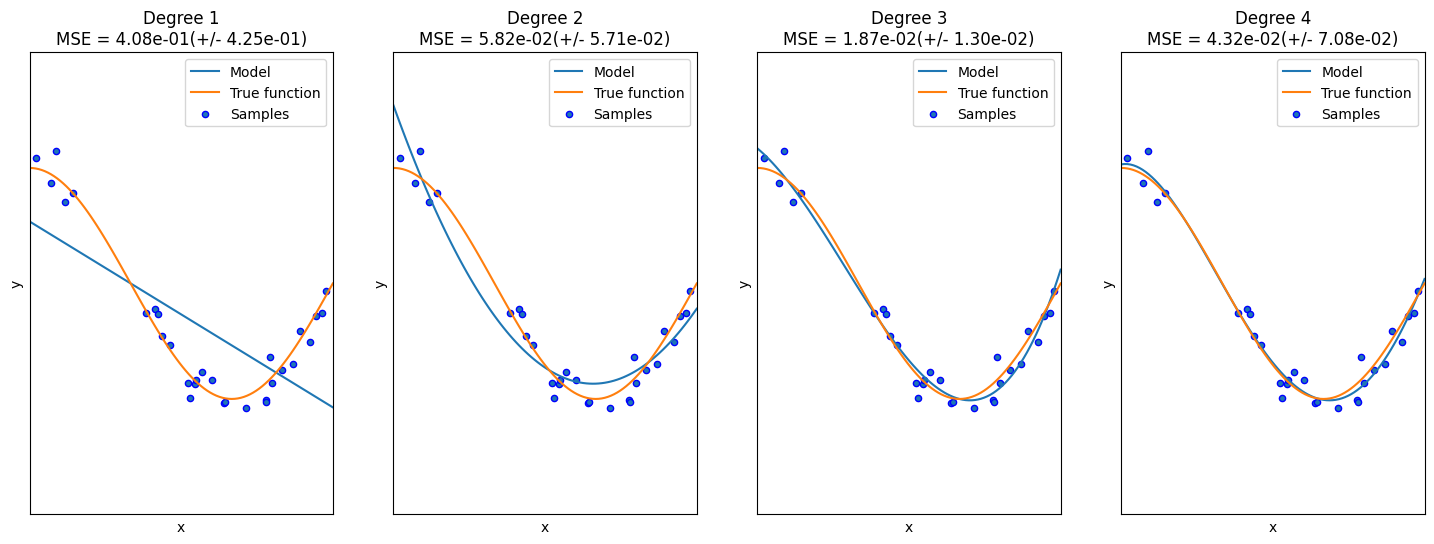

In [ ]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet


# Función verdadera: función basada en coseno
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# Fijar la semilla aleatoria para reproducibilidad
np.random.seed(0)

# Número de muestras
n_samples = 30
# Grados del modelo ajustado
degrees = [1, 2, 3, 4]

# Crear datos X que consisten de n_samples puntos
X = np.sort(np.random.rand(n_samples))
# Y es una función de X + algún componente de ruido
y = true_fun(X) + np.random.randn(n_samples) * 0.1

# Definir el tamaño de la figura
plt.figure(figsize=(18, 6))
# Iterar sobre la lista de grados
for i in range(len(degrees)):
    # Especificar la posición del gráfico
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    # Crear PolynomialFeatures con el grado correspondiente
    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    # Iniciar modelo de Regresión Lineal
    linear_regression = LinearRegression()
    # Crear un Pipeline con dos pasos:
    # 1. Crear características polinómicas
    # 2. Iniciar modelo de Regresión Lineal
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    # Ajustar el Pipeline
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluar los modelos usando validación cruzada
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)
    # Crear algunos puntos de prueba
    X_test = np.linspace(0, 1, 100)
    # Graficar valores predichos
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Modelo")
    # Graficar la función verdadera --> función antes de agregar ruido
    plt.plot(X_test, true_fun(X_test), label="Función verdadera")
    # Hacer todos los gráficos en tipo scatter plot
    plt.scatter(X, y, edgecolor='b', s=20, label="Muestras")
    # Especificar etiqueta X
    plt.xlabel("x")
    # Especificar etiqueta Y
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Grado {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

## ¿Qué Observamos en los Resultados?

### Grado 1 (Línea Recta)
❌ **Problema: Alto Sesgo (Underfitting)**
- El modelo es demasiado simple
- No sigue la curva de los datos
- Error alto → No captura el patrón real

### Grado 2 o 3
✅ **¡Buen Equilibrio!**
- El modelo sigue bien la forma de los datos
- No se pega demasiado a cada punto
- Error bajo y razonable

### Grado 4 o superior
❌ **Problema: Alta Varianza (Overfitting)**
- El modelo pasa por casi todos los puntos de entrenamiento
- Captura el ruido (las fluctuaciones aleatorias)
- Error muy bajo en entrenamiento, pero mal en datos nuevos

---

## Lección Clave

**No busques el modelo con menor error en entrenamiento.** Busca el modelo que:
1. Tenga error bajo en entrenamiento
2. Tenga error similar en validación/test
3. Sea lo más simple posible (principio de parsimonia)

# Regularización: Controlando la Complejidad

## ¿Qué es la Regularización?

Es una técnica para **evitar el sobreajuste** (alta varianza) penalizando los coeficientes muy grandes del modelo.

### ¿Por qué funciona?

Cuando un modelo tiene coeficientes muy grandes, significa que:
- Es muy sensible a pequeños cambios en los datos
- Está "memorizando" en lugar de "aprender"
- No generaliza bien

**La regularización limita el tamaño de los coeficientes**, obligando al modelo a ser más simple y robusto.

---

## Analogía Simple

Imagina que estás aprendiendo a cocinar:
- **Sin regularización**: Memorizas recetas exactas y fallas si falta 1 ingrediente
- **Con regularización**: Aprendes principios generales y puedes improvisar con lo que tienes

---


---

# 📦 Modelo en Producción: Guardando y Cargando el Modelo

Una vez que has encontrado el **mejor modelo (grado 3)**, necesitas **guardarlo** para usarlo en el futuro sin tener que reentrenarlo.

## 🎯 4 Pasos para Producción

### Paso 1️⃣: Entrenar y Guardar el Modelo

```python
import joblib

# 1. Entrenar el modelo grado 3 con TODOS tus datos
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

modelo_produccion = Pipeline([
    ("polynomial_features", PolynomialFeatures(degree=3, include_bias=False)),
    ("linear_regression", LinearRegression())
])

# Entrenar con todos los datos
modelo_produccion.fit(X, y)

# 2. Guardar el modelo
joblib.dump(modelo_produccion, 'modelo_grado3.joblib')

print("✅ Modelo guardado como 'modelo_grado3.joblib'")
```

---

### Paso 2️⃣: Cargar el Modelo Guardado

```python
import joblib

# En otro notebook o script diferente...
modelo_cargado = joblib.load('modelo_grado3.joblib')

print("✅ Modelo cargado exitosamente")
```

---

### Paso 3️⃣: Hacer Predicciones

```python
# Datos nuevos que llegan a producción
datos_nuevos = [[0.5], [0.7], [0.9]]

# Hacer predicciones
predicciones = modelo_cargado.predict(datos_nuevos)

print("Predicciones:", predicciones)
```

---

### Paso 4️⃣: Monitorear el Modelo

⚠️ **Importante:** En producción, debes verificar que el modelo sigue funcionando bien:

```python
from sklearn.metrics import mean_squared_error

# Cada semana/mes, recolecta predicciones y valores reales
error_produccion = mean_squared_error(y_real, y_predicho)

if error_produccion > umbral_aceptado:
    print("🚨 ALERTA: El modelo se está degradando")
    print("Necesitas reentrenarlo con datos más recientes")
else:
    print("✅ Modelo funcionando correctamente")
```

---

## 🔄 Flujo Completo en Producción

```
📊 Datos Nuevos (sensores, clientes, etc.)
    ↓
📦 Cargar modelo guardado (modelo_grado3.joblib)
    ↓
🎯 Hacer predicciones
    ↓
📤 Devolver resultado al usuario/sistema
    ↓
📈 Monitorear error y reentrenar si es necesario
```

---

## 💡 Lo Más Importante

1. **Entrena el mejor modelo** (valida con K-fold, elige el grado correcto)
2. **Guarda el modelo** con `joblib.dump()`
3. **Carga cuando necesites** con `joblib.load()`
4. **Haz predicciones** con `.predict()`
5. **Monitorea continuamente** el error en datos nuevos